In [1]:
# FAISS 影像檢索查詢系統 - 專注於載入與查詢，不進行建置。
import os
import numpy as np 
import faiss 
import torch
import torch.nn as nn
import torch.nn.functional as F 
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset 

In [2]:
# 嘗試導入 matplotlib 用於視覺化
try:
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    
except ImportError:
    plt = None
    print("⚠️ 警告: 找不到 'matplotlib' 庫。查詢結果將不會顯示圖片。")


In [3]:
# 1. 導入自定義模組與變換 
# ==============================================================================
try:
    # 假設您已定義了 model.py 中的 EmbeddingNet
    from model import EmbeddingNet
    
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD  = [0.229, 0.224, 0.225]
    IMAGE_SIZE = 224

    INFERENCE_TRANSFORMS = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ])
except ImportError:
    print("❌ 錯誤: 無法導入 'model' 模組。請確保 'model.py' 在當前目錄中。")
    class EmbeddingNet(nn.Module):
        def __init__(self, emb_size): super().__init__(); self.emb_size = emb_size
        def forward(self, x): return torch.randn(x.size(0), self.emb_size)
    INFERENCE_TRANSFORMS = transforms.ToTensor()

In [4]:
# 2. 環境設定與路徑
# ==============================================================================
# 假設您的模型和資料庫圖片位於這些路徑
MODEL_PATH = 'advanced_model.pth' # 來自 train_metric_advanced.py 訓練的最佳模型
EMBEDDING_SIZE = 512 # 應與 model.py 中的 EmbeddingNet 參數一致
DATABASE_IMAGES_DIR = 'deepfashion/images' # 圖片資料庫目錄 (用於建立索引)
FAISS_INDEX_PATH = 'faiss_index_gallery.bin' # FAISS 索引存儲路徑
EMBEDDINGS_NPY_PATH = 'indexed_advanced.npz' # 特徵向量存儲路徑

In [11]:
# 3. 核心函數
# ==============================================================================

def load_feature_extractor(model_path, embedding_size=512, device='cuda'):
    """ 載入訓練好的 EmbeddingNet 特徵提取模型。 """
    device = device if torch.cuda.is_available() else 'cpu'
    print(f"Loading model to device: {device}")

    model = EmbeddingNet(embedding_size=embedding_size).to(device)

    try:
        state = torch.load(model_path, map_location=device)
        
        if isinstance(state, dict) and 'model_state' in state:
            model.load_state_dict(state['model_state'])
        elif isinstance(state, dict):
            if all(k.startswith('module.') for k in state.keys()):
                state = {k[7:]: v for k, v in state.items()}
            model.load_state_dict(state)
        else:
            model.load_state_dict(state)

        model.eval() 
        print(f"✅ 模型載入成功: {os.path.basename(model_path)}")
        return model

    except Exception as e:
        print(f"❌ 錯誤: 無法載入模型 {model_path}。請確認路徑及模型檔案完整性。原因: {e}")
        return None


def load_embeddings_and_index(npy_path, index_path):
    """ 載入已存的特徵向量檔和 FAISS 索引。 """
    
    # 載入特徵向量文件 (包含檔名)
    indexed_file_names = None
    try:
        print(f"\n載入特徵向量文件名: {npy_path}")
        data = np.load(npy_path, allow_pickle=True)
        # 這裡只需要檔名，嵌入向量本身在查詢模式下是不需要的，但載入 numpy 檔時通常是整個載入
        indexed_file_names = data['filenames']
        all_embeddings = data['embeddings'] # 雖然不用，但載入是確保檔案完整性
        print(f"✅ 特徵文件載入完成。包含 {len(indexed_file_names)} 個檔名。")
    except Exception as e:
        print(f"❌ 錯誤: 無法載入特徵文件 {npy_path}。請確認檔案是否存在。原因: {e}")
        return None, None
    
    # 載入 FAISS 索引
    faiss_index = None
    try:
        print(f"\n載入已存 FAISS 索引: {index_path}")
        faiss_index = faiss.read_index(index_path)
        # *** 修正點: 確保使用 index.ntotal ***
        if faiss_index.ntotal != len(indexed_file_names):
             print(f"⚠️ 警告: 索引大小 ({faiss_index.ntotal}) 與檔名數量 ({len(indexed_file_names)}) 不匹配。")
        print(f"✅ FAISS 索引載入成功。Index Size: {faiss_index.ntotal}") 
    except AttributeError as e:
        # 捕捉 IndexFlatL2' object has no attribute 'nt' 類型的錯誤
        print(f"❌ 載入 FAISS 索引時發生屬性錯誤 (AttributeError): {e}")
        print("💡 可能是舊版 FAISS 索引檔案。請嘗試刪除舊索引檔 (`rm faiss_index_gallery.bin`) 後，執行建置程序。")
        faiss_index = None
    except Exception as e:
        print(f"❌ 載入 FAISS 索引時發生錯誤: {e}")
        faiss_index = None
        
    return faiss_index, indexed_file_names


def get_query_embedding(query_image_path, model):
    """ 處理單張查詢圖片，提取其特徵向量。 """
    if not os.path.exists(query_image_path):
        raise FileNotFoundError(f"查詢圖片不存在: {query_image_path}")

    img = Image.open(query_image_path).convert('RGB')
    tensor = INFERENCE_TRANSFORMS(img)
    tensor = tensor.unsqueeze(0) 

    device = next(model.parameters()).device 
    tensor = tensor.to(device)
    
    with torch.no_grad():
        embedding = model(tensor)
        embedding = F.normalize(embedding, p=2, dim=1) 
        
    return embedding.cpu().numpy()


def query_faiss_index(query_image_path, model, faiss_index, indexed_names, k=5):
    """ 執行 FAISS 查詢並返回結果。 """
    query_vector = get_query_embedding(query_image_path, model)
    distances, indices = faiss_index.search(query_vector, k) 

    results = []
    for rank, (index_in_db, distance) in enumerate(zip(indices[0], distances[0])):
        if index_in_db == -1: 
            break
        
        file_name = indexed_names[index_in_db]
        
        results.append({
            'rank': rank + 1,
            'file_name': file_name,
            'distance_L2': distance,
            'db_index': index_in_db,
        })
        
    return results

def visualize_results(query_path, results, db_root_dir, k=5):
    """ 使用 matplotlib 視覺化查詢圖片和 Top K 檢索結果。 """
    if plt is None:
        print("\n無法視覺化結果: 缺少 'matplotlib' 庫。")
        return
    
    try:
        # 創建一個 1 行 K+1 列的子圖，第一個是查詢圖片
        fig, axes = plt.subplots(1, k + 1, figsize=(3 * (k + 1), 3))
        
        # 1. 顯示查詢圖片 (Query Image)
        query_img = mpimg.imread(query_path)
        axes[0].imshow(query_img)
        axes[0].set_title(f"Query image:\n{os.path.basename(query_path)}", fontsize=10, color='blue')
        axes[0].axis('off')

        # 2. 顯示檢索結果 (Top K Results)
        for i, r in enumerate(results):
            if i >= k: break # 只顯示 Top K
                
            full_path = os.path.join(db_root_dir, r['file_name'])
            
            if os.path.exists(full_path):
                # 載入並顯示圖片
                result_img = mpimg.imread(full_path)
                axes[i + 1].imshow(result_img)
                axes[i + 1].set_title(
                    f"Rank {r['rank']}: {r['file_name']}\n(L2: {r['distance_L2']:.4f})",
                    fontsize=10
                )
                axes[i + 1].axis('off')
            else:
                # 如果圖片檔案遺失，顯示錯誤提示
                axes[i + 1].set_title(f"Rank {r['rank']}: Image Not Found", color='red')
                axes[i + 1].axis('off')

        plt.tight_layout()
        plt.show() 
        
    except Exception as e:
        print(f"\n❌ 視覺化圖片時發生錯誤: {e}")

In [11]:
# 4. 執行流程 (僅載入與查詢)
# ==============================================================================

print("=============================================================")
print("開始執行獨立查詢模式 (僅載入模型、特徵與索引)")
print("=============================================================")

# 1. 載入模型
feature_extractor_model = load_feature_extractor(MODEL_PATH, EMBEDDING_SIZE)
if feature_extractor_model is None:
    print("\n❌ 程式停止: 模型載入失敗。")
    exit()

# 2. 載入 FAISS 索引和特徵檔名
faiss_index, indexed_file_names = load_embeddings_and_index(EMBEDDINGS_NPY_PATH, FAISS_INDEX_PATH)

if faiss_index is None or indexed_file_names is None:
    print("\n❌ 程式停止: 索引或特徵檔載入失敗。請先執行建置程序。")
    exit()



開始執行獨立查詢模式 (僅載入模型、特徵與索引)
Loading model to device: cpu


/opt/conda/lib/python3.9/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 805: MPS client failed to connect to the MPS control daemon or the MPS server (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


✅ 模型載入成功: advanced_model.pth

載入特徵向量文件名: indexed_advanced.npz
✅ 特徵文件載入完成。包含 13752 個檔名。

載入已存 FAISS 索引: faiss_index_gallery.bin
✅ FAISS 索引載入成功。Index Size: 13752


In [15]:
#QUERY_IMAGE_EXAMPLE = os.path.join(DATABASE_IMAGES_DIR, "1000_031.jpg") # 範例查詢圖片
QUERY_IMAGE_EXAMPLE ="tommy_white_T-shirt.jpg"


開始執行範例查詢

========== 查詢結果 (Top 5) ==========
查詢圖片: tommy_white_T-shirt.jpg
Rank 1: 1443_051.jpg (L2 距離: 0.0219)
Rank 2: 4286_011.jpg (L2 距離: 0.0249)
Rank 3: 4991_042.jpg (L2 距離: 0.0249)
Rank 4: 5263_021.jpg (L2 距離: 0.0258)
Rank 5: 1125_031.jpg (L2 距離: 0.0269)


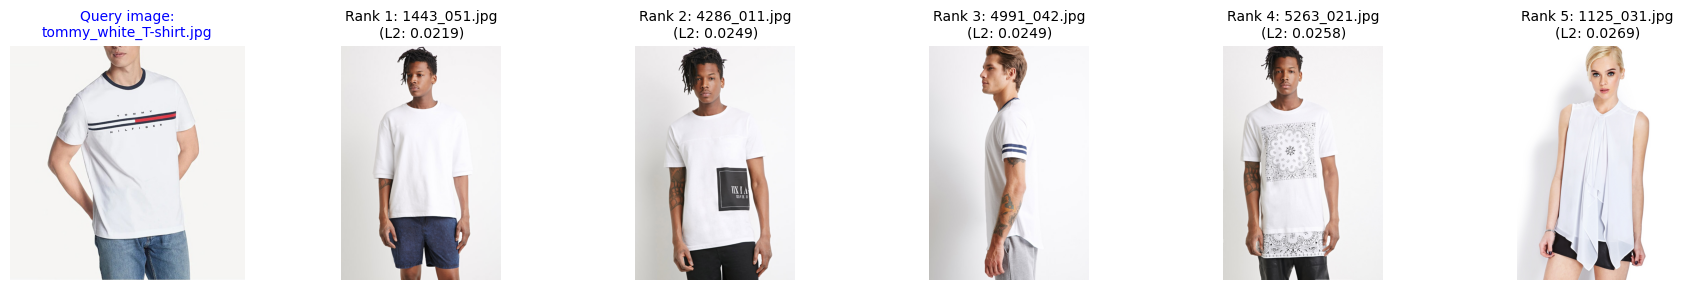

In [16]:
# 3. 執行查詢
print("\n" + "="*60)
print("開始執行範例查詢")
print("="*60)

if os.path.exists(QUERY_IMAGE_EXAMPLE):
    K_COUNT = 5 
    
    # 執行檢索
    try:
        results = query_faiss_index(
            query_image_path=QUERY_IMAGE_EXAMPLE,
            model=feature_extractor_model,
            faiss_index=faiss_index,
            indexed_names=indexed_file_names,
            k=K_COUNT
        )
        
        print(f"\n========== 查詢結果 (Top {K_COUNT}) ==========")
        print(f"查詢圖片: {os.path.basename(QUERY_IMAGE_EXAMPLE)}")
        for r in results:
            print(f"Rank {r['rank']}: {r['file_name']} (L2 距離: {r['distance_L2']:.4f})")
        print("==========================================")
        
        # 4. 視覺化結果
        visualize_results(QUERY_IMAGE_EXAMPLE, results, DATABASE_IMAGES_DIR, k=K_COUNT)


    except FileNotFoundError as e:
        print(f"\n❌ 查詢錯誤: {e}")
    except Exception as e:
        print(f"\n❌ 執行查詢時發生未知錯誤: {e}")

else:
    print(f"\n❌ 錯誤: 範例查詢圖片路徑不存在: {QUERY_IMAGE_EXAMPLE}")
